In [226]:
import os
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [227]:
#Globals for plotting
plot_w = 5
plot_h = 10

In [228]:
def sim_to_ep_metric_mapping(sim_metric_name): #Extend this if other metrics wanted crosscheck the report.txt and test_summary.csv for the names
    if sim_metric_name == 'Avg. Speed [m/s]':
        return 'Avg Speed'
    elif sim_metric_name == 'Avg. Absolute Path Error [m]':
        return 'Avg Absolute Path Error'
    else:
        return sim_metric_name

def extract_metric(report_path, metric_name):
    with open(report_path, 'r') as file:
        content = file.read()
        # Adjusted regex pattern to be more flexible with spaces and optional percentage sign
        match = re.search(rf'{re.escape(metric_name)}\s*\[?\%?\]?\s*([\d.]+)', content)
        if match:
            return float(match.group(1))
        else:
            return None

def collect_agent_metrics(base_dir, agent_name):
    '''
    Input: 
    base_dir - the directory where the results are stored, 
    agent_name - the name of the agent whose metrics are to be collected
    
    Output:
    metrics - a dictionary containing the average metrics for each scenario.
    n_episode_metrics - a dictionary containing the metrics over n episodes for each scenario.
    
    The Episode metrics df has the form {Collision:[n_ep metrics for scenario 1, n_ep metrics for scenario 2, ...], 
                                            Success: [n_ep metrics for scenario 1, n_ep metrics for scenario 2, ...], 
                                            ...}
    
    The code assumes that the test scenarios appear in the same order in the ../resultsgen/agent_name folder.
'''

    metrics = {
        'Collision Rate': [],
        'Success Rate': [],
        'Progression': [],
        'Avg. Number of Timesteps': [],
        'Avg. Speed [m/s]': [],
        'Avg. Absolute Path Error [m]': []
    }
    scenarios = []
    n_episode_metrics = {
        'Collision': [],
        'Success': [],
        'Progression': [],
        'Timesteps': [],
        'Avg Speed': [],
        'Avg Absolute Path Error': []
    }

    for test_scen in os.listdir(base_dir):
        test_scen_dir = os.path.join(base_dir, test_scen)
        if os.path.isdir(test_scen_dir):
            agent_dir_path = os.path.join(test_scen_dir, agent_name)
            report_path = os.path.join(agent_dir_path, 'report.txt')
            csv_path = os.path.join(agent_dir_path, 'test_summary.csv')
            if os.path.exists(report_path):
                for metric_name in metrics.keys():
                    metric_value = extract_metric(report_path, metric_name)
                    if metric_value is not None:
                        metrics[metric_name].append(metric_value)
                scenarios.append(test_scen)
            if os.path.exists(csv_path):
                n_ep_metrics_df = pd.read_csv(csv_path)
                for metric_name in n_episode_metrics.keys():
                    n_episode_metrics[metric_name].append(n_ep_metrics_df[metric_name].values)

    return metrics, n_episode_metrics, scenarios

def calculate_confidence_intervals(n_episode_metrics): #TODO verify this code
    confidence_intervals = {}
    for metric_name, values in n_episode_metrics.items():
        #print(metric_name, values)
        means = [np.mean(v) for v in values]
        sems = [np.std(v)/np.sqrt(len(v)) for v in values]
        cis = [1.96 * sem for sem in sems]
        confidence_intervals[metric_name] = (means, cis)
    return confidence_intervals

plt.style.use('ggplot')
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('axes', labelsize=12)
base_color = '#FF7F50'


def visualize_metrics(metrics, scenarios, metric_name, ylabel, show_ci=False, episode_metrics=None):
    values = metrics[metric_name]
    if show_ci:
        ep_metric_name = sim_to_ep_metric_mapping(metric_name)
        means, cis = calculate_confidence_intervals(episode_metrics)[ep_metric_name]

    fig, ax = plt.subplots(figsize=(plot_h, plot_w))
    if show_ci:
        ax.bar(scenarios, means, yerr=cis, color=base_color, edgecolor='black', linewidth=1.5, capsize=5)
    else:
        ax.bar(scenarios, values, color=base_color, edgecolor='black', linewidth=1.5)
    ax.set_xlabel('Scenarios')
    ax.set_ylabel(ylabel)
    ax.set_xticks(range(len(scenarios)))
    ax.set_xticklabels(scenarios, rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# def visualize_percentages_together_one_agent(metrics, scenarios): #Unused
#     metric_names = ['Success Rate', 'Collision Rate', 'Progression']
#     colors = ['#00E3D4', '#F68AF0', '#3343A7'] # cyan, pink, blue
#     percentage_metrics = {name: metrics[name] for name in metric_names}

#     x = np.arange(len(scenarios))
#     width = 0.2

#     fig, ax = plt.subplots(figsize=(12, 8))
    
#     for i, (metric_name, values) in enumerate(percentage_metrics.items()):
#         ax.bar(x + width*i, values, width, label=metric_name, color=colors[i])

#     ax.set_xlabel('Scenarios')
#     ax.set_ylabel('Percentage')
#     ax.set_xticks(x + width)
#     ax.set_xticklabels(scenarios, rotation=45, ha='right')
#     ax.legend()
#     plt.tight_layout()
#     plt.show()

def visualize_two_agents(metrics1, metrics2, scenarios, metric_name, ylabel, show_ci=False, episode_metrics1 =None, episode_metrics2=None, label1='Agent 1', label2='Agent 2'):
    values1 = metrics1[metric_name]
    values2 = metrics2[metric_name]
    if show_ci:
        ep_metric_name = sim_to_ep_metric_mapping(metric_name)
        means1, cis1 = calculate_confidence_intervals(episode_metrics1)[ep_metric_name]
        means2, cis2 = calculate_confidence_intervals(episode_metrics2)[ep_metric_name]

        print(means1, cis1)
        print(means2, cis2)

    x = np.arange(len(scenarios))
    width = 0.35

    fig, ax = plt.subplots(figsize=(plot_h, plot_w))
    if show_ci:
        ax.bar(x - width/2, means1, width, yerr=cis1, label=label1, color=base_color, edgecolor='black', linewidth=1.5, capsize=5)
        ax.bar(x + width/2, means2, width, yerr=cis2, label=label2, color='#F6DEB8', edgecolor='black', linewidth=1.5, capsize=5)
    else:
        ax.bar(x - width/2, values1, width, label=label1, color=base_color, edgecolor='black', linewidth=1.5)
        ax.bar(x + width/2, values2, width, label=label2, color='#F6DEB8', edgecolor='black', linewidth=1.5)

    ax.set_xlabel('Scenarios')
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(scenarios, rotation=45, ha='right')
    ax.legend()
    plt.tight_layout()
    plt.show()

def visualize_stacked_SR_CR(metrics1, scenarios, metrics2=None, agent_name1='Agent 1', agent_name2='Agent 2'):
    x = np.arange(len(scenarios))
    width = 0.35
    colors = ['#00E3D4', '#F68AF0', '#3343A7'] # cyan, pink, blue
    colors = ['#008B8B', 'magenta', '#89CFF0'] # Dark cyan, magenta, baby blue
    colors = ['#00E3D4', '#F68AF0', '#3343A7'] # cyan pink blue
    colors = ['#F6DEB8', '#A23C9D', '#FF7F50'] # tan darkmagenta coral
    fig, ax = plt.subplots(figsize=(plot_h, plot_w))

    if metrics2 is None:
        success_rates = metrics1['Success Rate']
        collision_rates = metrics1['Collision Rate']

        ax.bar(x, collision_rates, width, label='Collision Rate', color=colors[2],edgecolor='black', linewidth=1.5)
        ax.bar(x, success_rates, width, bottom=collision_rates, label='Success Rate', color=colors[0],edgecolor='black', linewidth=1.5)

    else:
        success_rates1 = metrics1['Success Rate']
        success_rates2 = metrics2['Success Rate']
        collision_rates1 = metrics1['Collision Rate']
        collision_rates2 = metrics2['Collision Rate']

        ax.bar(x - width/2, success_rates1, width,  label=f'Success Rate {agent_name1}', color=colors[2],edgecolor='black', linewidth=1.5)#, hatch='//')
        ax.bar(x + width/2, success_rates2, width,  label=f'Success Rate {agent_name2}', color=colors[0],edgecolor='black', linewidth=1.5)#, hatch='o')
        
        ax.bar(x - width/2, collision_rates1, width, bottom=success_rates1, label=f'Collision Rate {agent_name1}', color=colors[2], hatch='xx',edgecolor='black', linewidth=1.5)
        ax.bar(x + width/2, collision_rates2, width, bottom=success_rates2, label=f'Collision Rate {agent_name2}', color=colors[0], hatch='xxx',edgecolor='black', linewidth=1.5)

    ax.set_xlabel('Scenarios')
    ax.set_ylabel('Percentage')
    ax.set_xticks(x)
    ax.set_xticklabels(scenarios, rotation=45, ha='right')
    ax.legend()
    ax.set_ylim(top=ax.get_ylim()[1] * 1.02)  # Increase the upper limit by 2%
    plt.tight_layout()
    plt.show()

### Available metrics:
```'Collision Rate'```

```'Success Rate'```

```'Progression'```

```'Avg. Number of Timesteps'```

```'Avg. Speed [m/s]'```

```'Avg. Absolute Path Error [m]'```

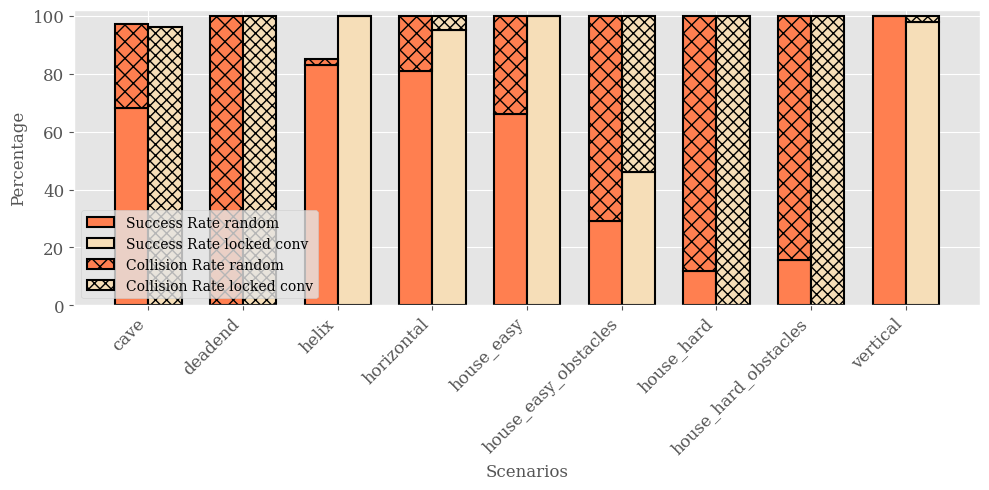

In [229]:
#### The random agent ####
exp_dir_path = 'Best_agent_res_gen_2 exp 32'
trained_scen = "advanced"
base_dir = f'../log/LV_VAE_MESH-v0/{exp_dir_path}/{trained_scen}/results_gen'

agent_name = "test_agent_model_10000"
metrics1,n_ep_met1, scenarios1 = collect_agent_metrics(base_dir, agent_name)

#### The locked conv agent ####
exp_dir_path = 'Best_agent_res_gen_1 exp 10005'
trained_scen = "proficient_perturbed"
base_dir = f'../log/LV_VAE_MESH-v0/{exp_dir_path}/{trained_scen}/results_gen'

agent_name = "test_agent_model_180000"
metrics2,n_ep_met2, scenarios2 = collect_agent_metrics(base_dir,agent_name)

####The unlocked agent #### worse than the two above
# exp_dir_path = 'A_maybe_best_pt_unlocked 10006'
# trained_scen = "expert_perturbed"
# base_dir = f'../log/LV_VAE_MESH-v0/{exp_dir_path}/{trained_scen}/results_gen'
# agent_name = "test_agent_model_30000"
# metrics3,n_ep_met3, scenarios3 = collect_agent_metrics(base_dir, agent_name)


assert scenarios1 == scenarios2 

visualize_stacked_SR_CR(metrics1, scenarios2, metrics2, agent_name1='random', agent_name2='locked conv')

# visualize_stacked_SR_CR(metrics3, scenarios2, metrics2, agent_name1='unlocked', agent_name2='locked_conv')


[0.7504833078550542, 0.6787126395245258, 0.999114316502241, 0.8872478352482877, 0.78679077545269, 0.6513364491897228, 0.4819396095916592, 0.47379102408827195, 0.9552214561232768] [0.074058573341614, 0.0009084564838945663, 0.00023101796877787032, 0.03906798667095472, 0.05552919270161708, 0.04857795725429269, 0.04389993032188363, 0.05319772738519598, 0.0017123329377935685]
[0.3834996934491951, 0.6711907900438129, 0.9969970926088629, 0.9348889600990314, 0.9629381505176916, 0.7155720886559288, 0.3522267802096716, 0.4119431056532509, 0.9596633702780529] [0.07680947250056805, 0.0007355700662940818, 1.7488279194543606e-05, 0.02098006880292911, 0.0014786620202612924, 0.052935259047254754, 0.01655222077044743, 0.012613294605540374, 0.013774752990830546]


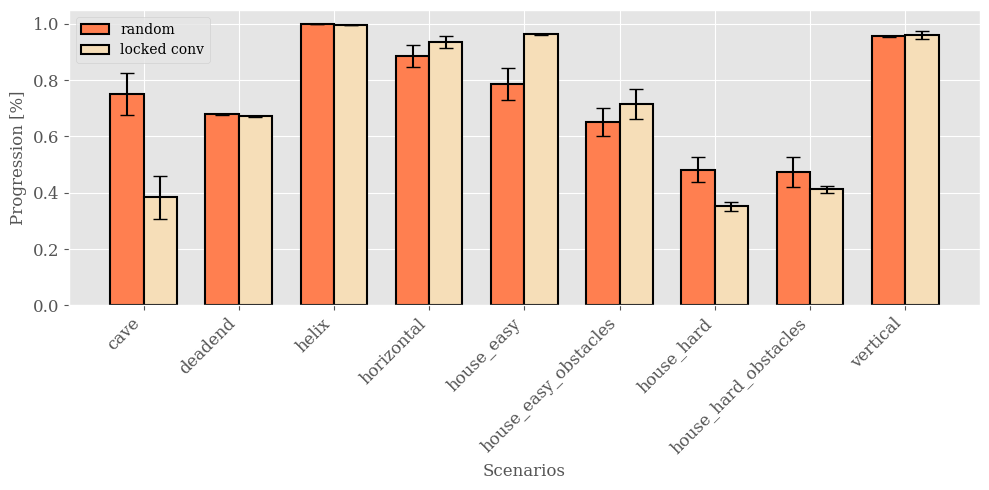

In [230]:
visualize_two_agents(metrics1, metrics2, scenarios1, 'Progression', 'Progression [%]',label1='random', label2='locked conv',show_ci=True, episode_metrics1=n_ep_met1, episode_metrics2=n_ep_met2)

[0.9238550398394781, 1.0177132506684563, 1.0966472181309113, 1.109270507696715, 0.9293389697480862, 0.9440362026742699, 0.7585098217794397, 0.7767466748928364, 1.1871230807845552] [0.044480898587517026, 0.008975201423217154, 0.005949542266531663, 0.025151293454632743, 0.023521751452656024, 0.020237192348059072, 0.015367000949521413, 0.01917466896388608, 0.016463919251850558]
[0.7430011992096459, 1.1388141426657006, 1.0396557635408732, 1.0668534708477353, 0.9430944449925726, 0.9305469294413733, 0.7944612277343839, 0.8073135470757498, 1.1147935196183172] [0.04507742668024015, 0.005734504792244862, 0.001544622154106482, 0.0181206839443302, 0.007033894949573677, 0.014436829925581986, 0.009292454178939947, 0.0076431317557218055, 0.018718258070040055]


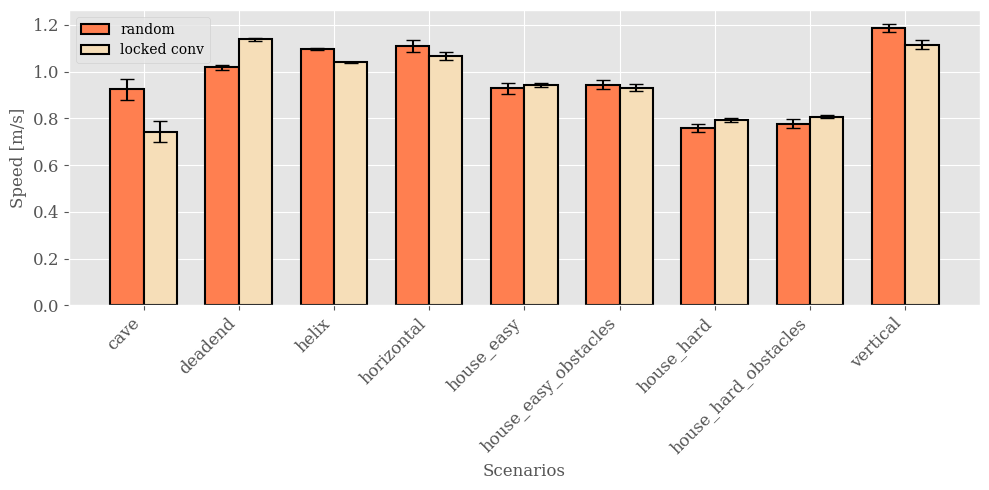

In [231]:
visualize_two_agents(metrics1, metrics2, scenarios1, 'Avg. Speed [m/s]', 'Speed [m/s]',label1='random', label2='locked conv', show_ci=True, episode_metrics1=n_ep_met1, episode_metrics2=n_ep_met2)

[0.9093000275048123, 4.7996769829812855, 1.4135256052826852, 1.5017904859256381, 0.29774500093665207, 0.2905541255712572, 0.21734061637201724, 0.23096792190342375, 1.051898350909719] [0.22045087108555217, 0.10110340448418427, 0.017065998171686584, 0.04901488216905093, 0.014255019982888402, 0.014343339578924943, 0.008694105303042805, 0.010132390901148128, 0.050978935675026336]
[1.9583318799510763, 0.5001290250724756, 0.5991557696726812, 0.9142904814139656, 0.2629673276070687, 0.31663822897570704, 0.21107697664764583, 0.25651327629563847, 0.9979968942668189] [0.2534335477113592, 0.028427315283529132, 0.0072067455970981215, 0.06261217307357542, 0.006914777844843906, 0.012576640821505732, 0.012921998648430553, 0.00894679954292006, 0.04588092869327776]


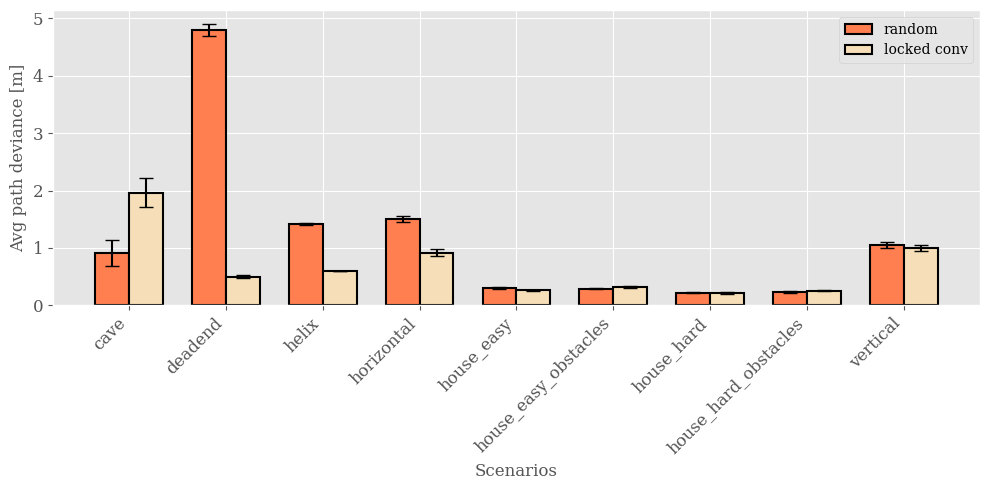

In [232]:
visualize_two_agents(metrics1, metrics2, scenarios1, 'Avg. Absolute Path Error [m]', 'Avg path deviance [m]',label1='random', label2='locked conv', show_ci=True, episode_metrics1=n_ep_met1, episode_metrics2=n_ep_met2)

### Single plotting, not used honestly

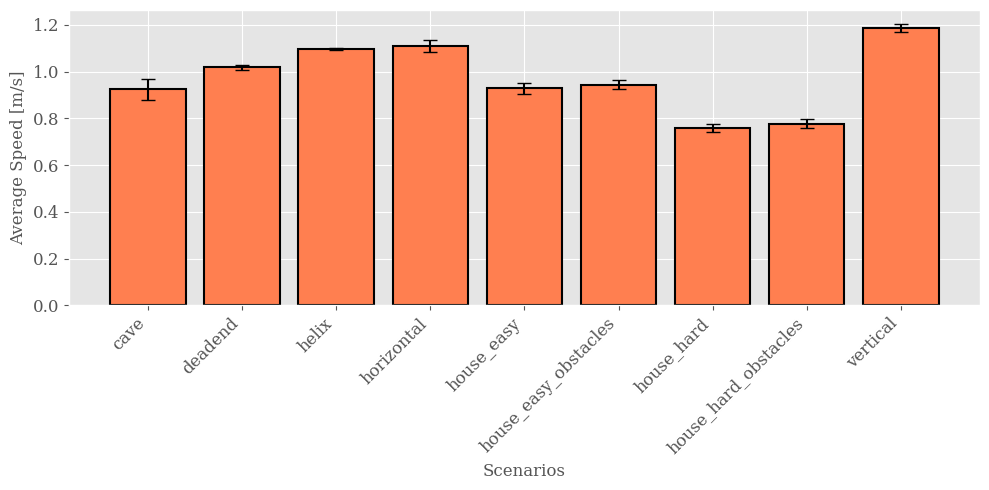

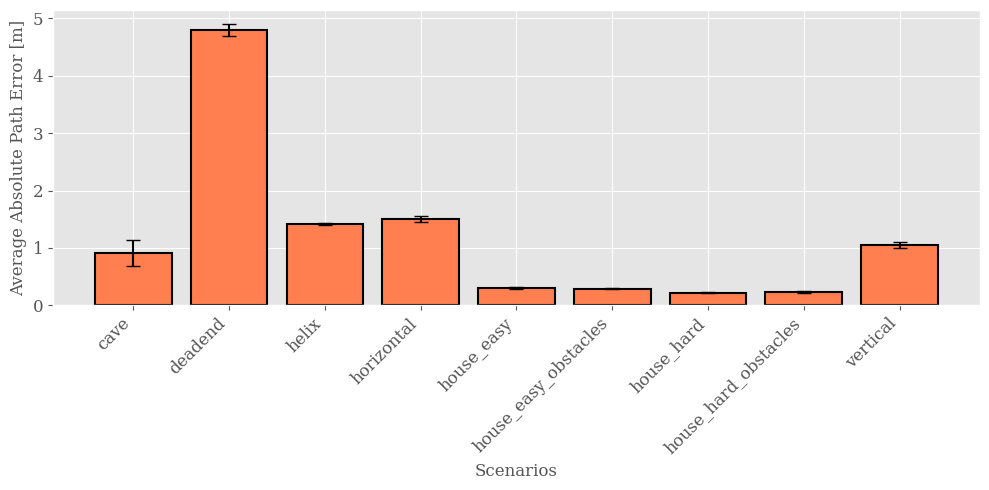

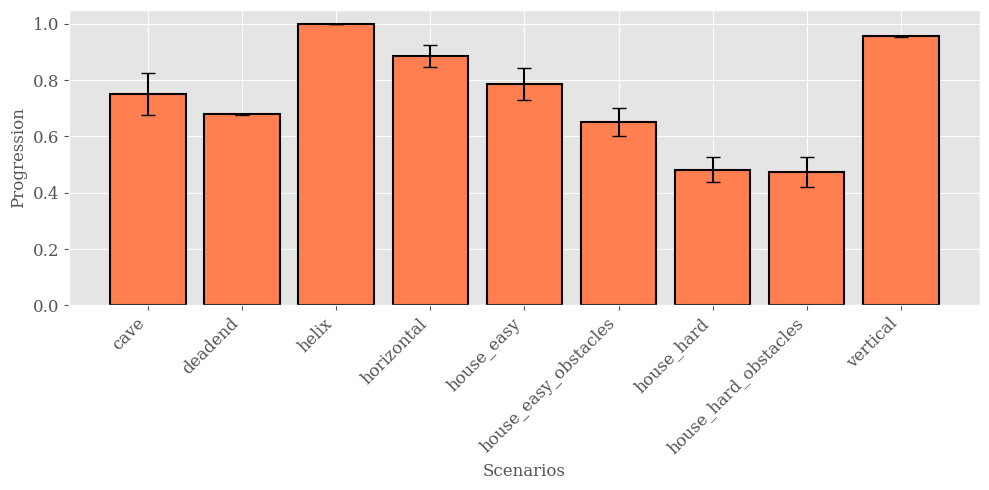

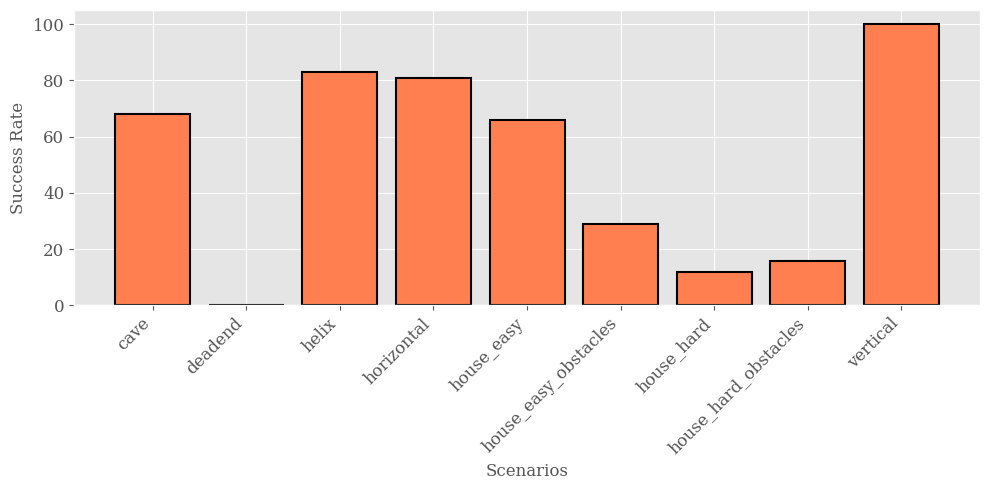

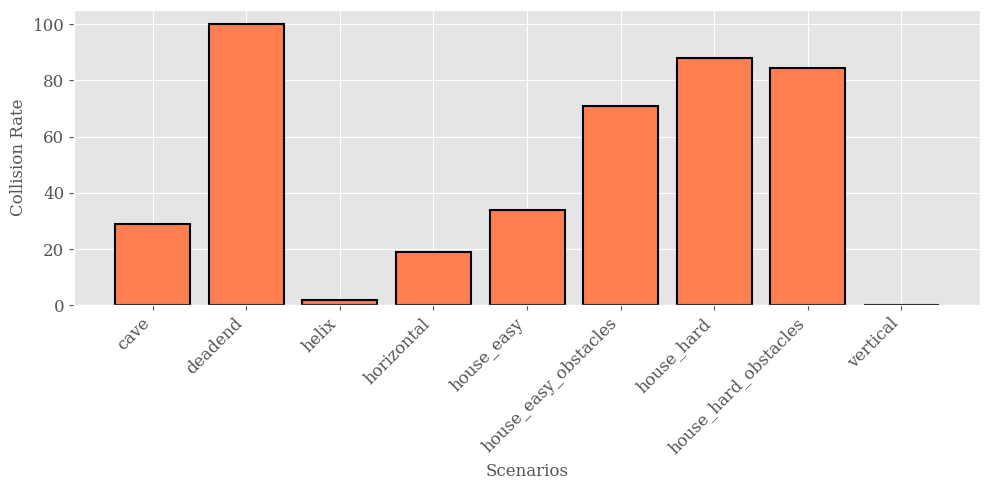

In [233]:
exp_id = 32
trained_scen = "advanced"
agent_name = "test_agent_model_10000" 
exp_dir_path = f'Best_agent_res_gen_2 exp {exp_id}'
base_dir = f'../log/LV_VAE_MESH-v0/{exp_dir_path}/{trained_scen}/results_gen'

metrics, epmet, scenarios = collect_agent_metrics(base_dir, agent_name)
# For single metric visualization
#The metrics that need CI
visualize_metrics(metrics, scenarios, 'Avg. Speed [m/s]', 'Average Speed [m/s]', show_ci=True, episode_metrics=epmet)
visualize_metrics(metrics, scenarios, 'Avg. Absolute Path Error [m]', 'Average Absolute Path Error [m]', show_ci=True, episode_metrics=epmet)
visualize_metrics(metrics, scenarios, 'Progression', 'Progression', show_ci=True, episode_metrics=epmet)
#Percentages dont need CI (?)
visualize_metrics(metrics, scenarios, 'Success Rate', 'Success Rate')
visualize_metrics(metrics, scenarios, 'Collision Rate', 'Collision Rate')
# visualize_metrics(metrics, scenarios, 'Avg. Number of Timesteps', 'Average Number of Timesteps') #Unused

# For combined percentage metrics visualization (unused)
# visualize_percentages_together_one_agent(metrics, scenarios)